In [1]:
import matplotlib
%matplotlib inline

import matplotlib.pyplot as plt
import matplotlib.cm as cm
from IPython.display import display, clear_output

import time
from tqdm.notebook import tqdm
import numpy as np
import dask.array.image
import mrcfile

import torch
from torch import nn, optim
from torch.utils.tensorboard import SummaryWriter

In [2]:
X = []
for i in range(8):
  with mrcfile.open(f'../../data/shrec2021_contest_dataset/model_{i}/class_mask.mrc') as mrc:
    cryoet = mrc.data
    
    nonzero_layers = np.sum(np.sum(cryoet, axis=1), axis=1) > 0
    # Let's hope the non-zero band is continuous
    X.append(cryoet[nonzero_layers])
    
    if i == 0:
      print(cryoet.shape)
      print(X[0].shape)

(512, 512, 512)
(180, 512, 512)


In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [4]:
n_data_channes = 3


class Transpose(nn.Module):
  def __init__(self, dim0, dim1):
    super(Transpose, self).__init__()
    self.dims = [ dim0, dim1 ]

  def forward(self, input):
    return torch.transpose(input, self.dims[0], self.dims[1])


class CryoETPatterns(nn.Module):
  def __init__(self):
    super(CryoETPatterns, self).__init__()
    base_n_filters = 8
    self.main = nn.Sequential(
      nn.Conv3d(n_data_channes, base_n_filters, 5, 2, 0, bias=False),
      nn.BatchNorm3d(base_n_filters),
      nn.ReLU(True),
      nn.Conv3d(base_n_filters, base_n_filters * 2, 5, 2, 0, bias=False),
      nn.BatchNorm3d(base_n_filters * 2),
      nn.ReLU(True),
      nn.Conv3d(base_n_filters * 2, base_n_filters * 4, 5, 2, 0, bias=False),
      nn.BatchNorm3d(base_n_filters * 4),
      nn.ReLU(True),
      nn.Conv3d(base_n_filters * 4, base_n_filters * 8, 5, 2, 0, bias=False),
      nn.BatchNorm3d(base_n_filters * 8),
      nn.ReLU(True),
      nn.Flatten(2, -1),
      Transpose(1, 2),
      nn.Linear(base_n_filters * 8, 2),
      Transpose(1, 2),
      nn.AdaptiveAvgPool1d(1),
      nn.Flatten(1, -1),
      nn.Softmax(),
    )

  def forward(self, input):
    return self.main(input)

In [5]:
torch.manual_seed(0)

cryoet_patterns = CryoETPatterns().to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(cryoet_patterns.parameters(), lr=1e-3, betas=(0.5, 0.999))

batch_size = 16
negative_percent = 0.7


def gen_inputs(batch_size, negative_percent):
  n_negative = int(batch_size * negative_percent)
  n_positive = batch_size - n_negative
  sample_size = 61
  
  scan_idx = np.random.randint(0, len(X))
  
  # Take positive samples
  positive_positions = np.random.randint(
    [0, 0, 0],
    np.array(X[scan_idx].shape) - sample_size,
    size=(n_positive, 3)
  )
  positive = np.stack([
    X[scan_idx][
      positive_positions[i, 0]:positive_positions[i, 0] + sample_size,
      positive_positions[i, 1]:positive_positions[i, 1] + sample_size,
      positive_positions[i, 2]:positive_positions[i, 2] + sample_size
    ] for i in range(n_positive)
  ])
  
  # Generate negative samples
  negative_positions = np.random.randint(
    [0, 0, 0],
    np.array(X[scan_idx].shape) - sample_size,
    size=(n_negative, 3)
  )
  negative = np.stack([
    X[scan_idx][
      negative_positions[i, 0]:negative_positions[i, 0] + sample_size,
      negative_positions[i, 1]:negative_positions[i, 1] + sample_size,
      negative_positions[i, 2]:negative_positions[i, 2] + sample_size
    ] for i in range(n_negative)
  ])
  n_block_swaps = 5
  block_swap_extents = [ 11, 31 ]
  # Perform `n_block_swaps` content swaps for negative samples to distort their content
  # TODO: add more distortion techniques
  for i in range(n_block_swaps):
    block_sizes = np.random.randint(block_swap_extents[0], block_swap_extents[1], size=(n_negative, 3))
    block_source_positions = np.random.randint(
      np.zeros((n_negative, 3)),
      np.ones((n_negative, 3)) * np.array([negative.shape[1:]]) - block_sizes
    )
    block_target_positions = np.random.randint(
      np.zeros((n_negative, 3)),
      np.ones((n_negative, 3)) * np.array([negative.shape[1:]]) - block_sizes
    )
    for j in range(n_negative):
      # Swap the blocks at target and source positions
      tmp_blocks = negative[
        j,
        block_target_positions[j, 0]:block_target_positions[j, 0] + block_sizes[j, 0],
        block_target_positions[j, 1]:block_target_positions[j, 1] + block_sizes[j, 1],
        block_target_positions[j, 2]:block_target_positions[j, 2] + block_sizes[j, 2]
      ].copy()
      negative[
        j,
        block_target_positions[j, 0]:block_target_positions[j, 0] + block_sizes[j, 0],
        block_target_positions[j, 1]:block_target_positions[j, 1] + block_sizes[j, 1],
        block_target_positions[j, 2]:block_target_positions[j, 2] + block_sizes[j, 2]
      ] = negative[
        j,
        block_source_positions[j, 0]:block_source_positions[j, 0] + block_sizes[j, 0],
        block_source_positions[j, 1]:block_source_positions[j, 1] + block_sizes[j, 1],
        block_source_positions[j, 2]:block_source_positions[j, 2] + block_sizes[j, 2]
      ]
      negative[
        j,
        block_source_positions[j, 0]:block_source_positions[j, 0] + block_sizes[j, 0],
        block_source_positions[j, 1]:block_source_positions[j, 1] + block_sizes[j, 1],
        block_source_positions[j, 2]:block_source_positions[j, 2] + block_sizes[j, 2]
      ] = tmp_blocks
  
  samples = np.concatenate([
    positive,
    negative,
  ])
  samples = np.stack([
    np.ones(samples.shape) * (samples == 14),  # vesicles
    np.ones(samples.shape) * ((samples > 0) & (samples < 14)),  # proteins
    np.ones(samples.shape) * ((samples == 0)),  # background
  ])
  samples = np.transpose(samples, (1, 0, 2, 3, 4))
  labels = np.concatenate([
    np.ones(n_positive) * 0,
    np.ones(n_negative) * 1
  ])
  return torch.from_numpy(samples.astype(np.float32)).to(device), torch.from_numpy(labels.astype(np.int64)).to(device)


writer = SummaryWriter(f'runs/{time.time()}')
for step in tqdm(range(100)):
  cryoet_patterns.zero_grad()
  inputs, labels = gen_inputs(batch_size, negative_percent)
  pred = cryoet_patterns(inputs)
  loss = criterion(pred, labels)
  #print(np.sum(np.argmax(pred.detach().cpu().numpy(), axis=-1) != labels.cpu().numpy()))
  writer.add_scalar('loss', loss.item(), step)
#   print(loss)
  loss.backward()
  optimizer.step()
writer.close()

C:\Users\ghost\anaconda3\lib\site-packages\torch\nn\modules\container.py:119: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


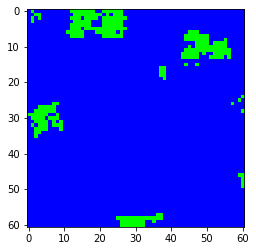

In [6]:
plt.imshow(np.transpose(inputs[11, :, 12].cpu().numpy(), (1, 2, 0)))

In [9]:
def separate_samples_info_channels(samples):
  samples = np.stack([
    np.ones(samples.shape) * (samples == 14),  # vesicles
    np.ones(samples.shape) * ((samples > 0) & (samples < 14)),  # proteins
    np.ones(samples.shape) * ((samples == 0)),  # background
  ])
  samples = np.transpose(samples, (1, 0, 2, 3, 4))
  return samples.astype(np.float32)


original_cryoet = separate_samples_info_channels(
  np.expand_dims(
    np.concatenate([
      np.zeros((50, X[0].shape[1], X[0].shape[2])),
      X[0],
      np.zeros((50, X[0].shape[1], X[0].shape[2])),
    ]),
    axis=0
  )
)

inferred_cryoet = torch.from_numpy(
  separate_samples_info_channels(
    np.expand_dims(
      np.concatenate([
        np.zeros((50, X[0].shape[1], X[0].shape[2])),
        X[0],
        np.zeros((50, X[0].shape[1], X[0].shape[2])),
      ]),
      axis=0
    )
  )
).to(device)

target_label = torch.from_numpy(np.array([0], dtype=np.int64)).to(device)


infer_optimizer = optim.Adam([inferred_cryoet.requires_grad_()], lr=1e-2, betas=(0.5, 0.999))
#infer_optimizer = optim.LBFGS([inferred_cryoet.requires_grad_()], history_size=10)

for step in tqdm(range(50)):
  def closure():
    infer_optimizer.zero_grad()
    pred = cryoet_patterns(inferred_cryoet)
    loss = criterion(pred, target_label)
    print(loss.item())
    loss.backward()
    return loss
  
  infer_optimizer.step(closure)

1.096387267112732
1.0686646699905396
1.0460145473480225
1.0256158113479614
1.0084915161132812
0.995896577835083
0.9863584041595459
0.9775537252426147
0.9659780859947205
0.9541198015213013
0.9444862604141235
0.9374495148658752
0.9311749935150146
0.9207172393798828
0.908862292766571
0.9006596207618713
0.8912556767463684
0.8839222192764282
0.8718980550765991
0.8588817119598389
0.8490452766418457
0.8398215770721436
0.8333724737167358
0.824457049369812
0.8169662952423096
0.8105403184890747
0.8016054630279541
0.7912697196006775
0.7814111709594727
0.7701777219772339
0.7619258761405945
0.754632830619812
0.7504615783691406
0.7451289892196655
0.7404809594154358
0.7299087047576904
0.722631573677063
0.7157062292098999
0.7129544019699097
0.7069436311721802
0.7025809288024902
0.6957467794418335
0.6877816319465637
0.6807776093482971
0.6744823455810547
0.6681115627288818
0.661512553691864
0.6558518409729004
0.6531161665916443
0.6531933546066284



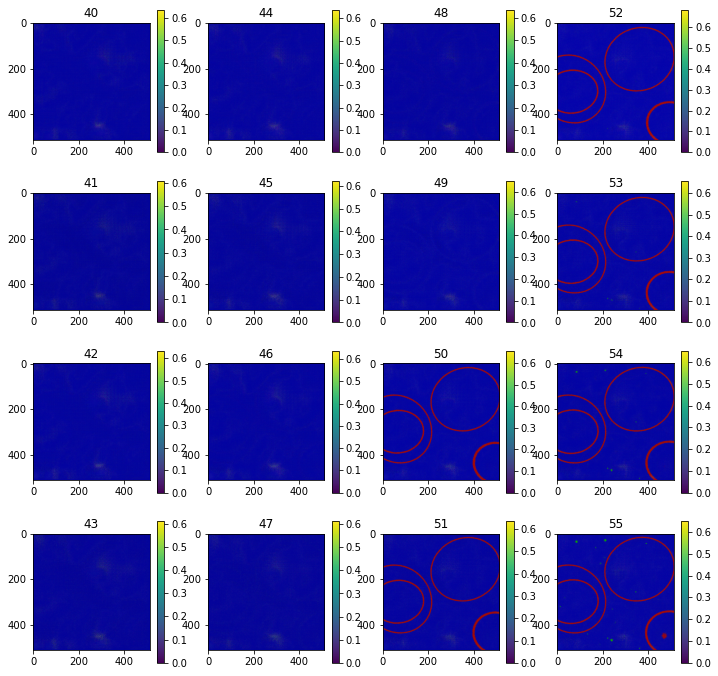

In [11]:
#print(np.sum(np.abs(original_cryoet - inferred_cryoet.detach().cpu().numpy()), (1, 3, 4)))
inferred_cryoet_cpu = inferred_cryoet.detach().cpu().numpy()
fig, ax = plt.subplots(4, 4, figsize=(12, 12))
for i in range(16):
  z_layer = 40 + i
  m = ax[i % 4][i // 4].imshow(
#     np.sum(
#       np.transpose(inferred_cryoet_cpu[0, :, z_layer], (1, 2, 0)),
#       2
#     )
    np.abs(np.clip(np.transpose(inferred_cryoet_cpu[0, :, 40 + i], (1, 2, 0)), -1, 1)) / np.max(inferred_cryoet_cpu[0, :, 40 + i]),
  )
  ax[i % 4][i // 4].set_title(z_layer)
  fig.colorbar(m, ax=ax[i % 4][i // 4])